In [74]:
import h5py
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pprint
import random
import skimage.io as io
from random import randint

To get the results file from Google Storage bucket (assuming you have access):


```
gsutil cp gs://mids-w266-mw/mlflow/52/c8947e37d27b40babbbf9e2008fec45f/artifacts/attention_prob_mrr_san_expt28_2018-12-07-00:47:53.hdf5 .
gsutil cp gs://mids-w266-mw/mlflow/52/c8947e37d27b40babbbf9e2008fec45f/artifacts/test2015_results_mrr_san_expt28_2018-12-07-00:47:53.json .
```

### Load the Attention Prob. and Predicted Answers Json

In [75]:
# Best model
probs_path = '/home/ubuntu/attn_layer/w266-final-project/vqa/results/best_attn_prob.hdf5'
json_results_path = '/home/ubuntu/attn_layer/w266-final-project/vqa/results/best_answer_file.json'

In [76]:
probs = []

with h5py.File(probs_path, 'r') as f:
    for k in f.keys():
        print(k)
        probs.append(np.array(f.get(k)))

with open(json_results_path) as f:
    resultsj = json.load(f)


attention_probabilites0
attention_probabilites1


### Note that there are 2 attention Layer probabilities 

### Truncate the probability array to match the answer array.
#### we assume that they are in the exact same sequence

In [77]:
test_set_length = len(resultsj)
print('json results length: {}'.format(test_set_length))

print('# datasets:',len(probs))
for i in range(len(probs)):
    print('dataset {} padded shape: {}'.format(i, probs[i].shape))
    probs[i] = probs[i][:test_set_length]
    print('dataset {} truncated to: {}'.format(i, probs[i].shape))



json results length: 52213
# datasets: 2
dataset 0 padded shape: (52300, 196, 1)
dataset 0 truncated to: (52213, 196, 1)
dataset 1 padded shape: (52300, 196, 1)
dataset 1 truncated to: (52213, 196, 1)


In [78]:
# sample
resultsj[0]

{'predicted_answer': 'white',
 'question_id': 5161941,
 'question_str': 'what color is the cat',
 'question_type': 'what color is the',
 'complement_id': None,
 'image_id': 516194,
 'answer_id': 51619410,
 'answer_str': 'black and white',
 'one_hot_index': 32,
 'answer_type': 'other',
 'annotations': ['black and white',
  'black and white',
  'black and white',
  'black and white',
  'black and white',
  'black and white',
  'black and white',
  'black and white',
  'black and white',
  'black and white']}

In [79]:
def get_image_path(img_id):
    ID_DIGITS = 12
    img_id_len = len(str(img_id))
    img_path = '/home/ubuntu/vqa_data/images/mscoco/val2014/COCO_val2014_{}{}.jpg'.format((ID_DIGITS - img_id_len)*'0', img_id)
    return img_path

In [83]:
from skimage.transform import resize
import cv2                                                


def show_image(img_path,idx):
    if os.path.isfile(img_path):
        image = io.imread(img_path)
        image = cv2.resize(image,(448,448))
        heatmap = cv2.resize(np.reshape(probs[0][idx,:,:],(14,14)), (448, 448))   
        heatmap = np.tile(heatmap,(3,1,1))
        heatmap = np.moveaxis(heatmap,0,-1)
        
        print("Superimposed Image with Attention Layer 1")
        plt.figure(figsize=(7,7))
        superimposed_img = heatmap * image
        superimposed_img[superimposed_img > 1] = 1
        plt.imshow(superimposed_img)
        plt.axis('on')
        plt.show()
        
        heatmap = cv2.resize(np.reshape(probs[1][idx,:,:],(14,14)), (448, 448))   
        heatmap = np.tile(heatmap,(3,1,1))
        heatmap = np.moveaxis(heatmap,0,-1)
        plt.figure(figsize=(7,7))
        print("Superimposed Image with Attention Layer 2")
        superimposed_img = heatmap * image
        superimposed_img[superimposed_img > 1] = 1
        plt.imshow(superimposed_img)
        plt.axis('on')
        plt.show()
        
    return image.shape

In [84]:
num_samples = 3
rand_indices = [randint(0, len(resultsj)) for s in range(0, num_samples)]
rand_results, rand_image_ids, rand_image_paths, rand_question_strs, rand_answer_strs = [], [], [], [], []

for i in rand_indices:
    rand_results.append(resultsj[i])
    rand_image_ids.append(resultsj[i]['image_id'])
    rand_image_paths.append(get_image_path(resultsj[i]['image_id']))
    rand_question_strs.append(resultsj[i]['question_str'])
    rand_answer_strs.append(resultsj[i]['answer_str'])
    
# pprint.pprint (rand_results)
#print (rand_indices)
#print (rand_image_ids)
#print (rand_image_paths)
#print (rand_question_strs)
#print (rand_answer_strs)



Image Path : /home/ubuntu/vqa_data/images/mscoco/val2014/COCO_val2014_000000223574.jpg
Question : does there appear to be an emergency
Answer : yes
Superimposed Image with Attention Layer 1


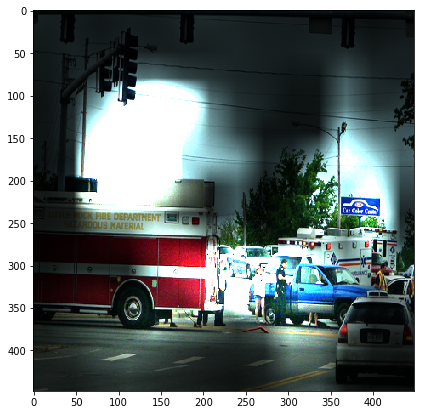

Superimposed Image with Attention Layer 2


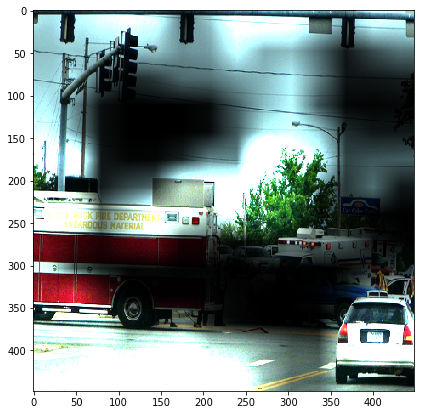

________________________________________________________________________________

Image Path : /home/ubuntu/vqa_data/images/mscoco/val2014/COCO_val2014_000000409088.jpg
Question : did someone forget to throw the wrapper away
Answer : yes
Superimposed Image with Attention Layer 1


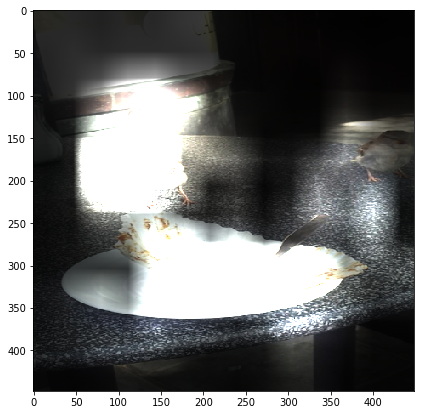

Superimposed Image with Attention Layer 2


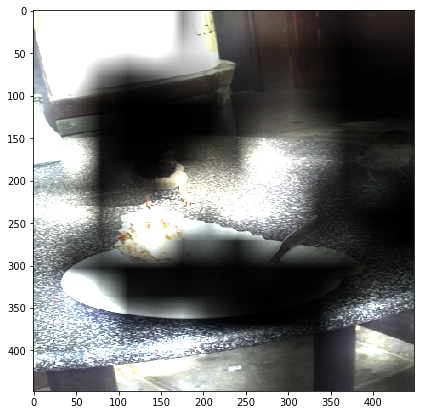

________________________________________________________________________________

Image Path : /home/ubuntu/vqa_data/images/mscoco/val2014/COCO_val2014_000000471842.jpg
Question : what type of fork is shown
Answer : knife
Superimposed Image with Attention Layer 1


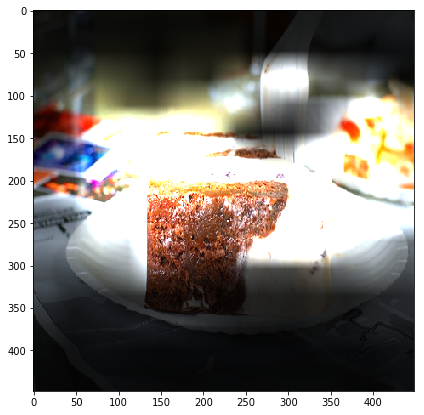

Superimposed Image with Attention Layer 2


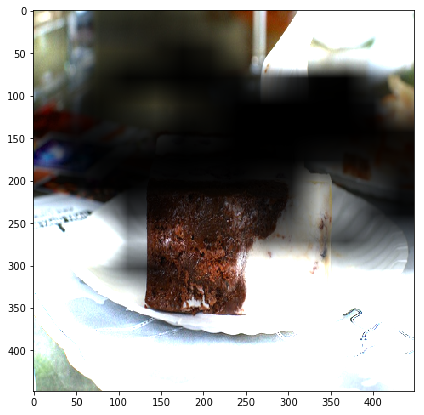

________________________________________________________________________________



In [85]:
for idx, p in enumerate(rand_image_paths):
    print(f"Image Path : {p}")
    print(f"Question : {rand_question_strs[idx]}")
    print(f"Answer : {rand_results[idx]['predicted_answer']}")
    image_dims = show_image(p,idx)
    print("_"*80)
    print()
